# K-nearest Implementation

This file includes an implementation for nested cross-validation and the k-nearest neighbour algorithm, evaluation via confusion matrices, and an estimate distances between data samples.

## 1. Exploratory Data Analysis

In this notebook we are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features.

In [4]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

### Additional EDA
I have added my own EDA code to better understand the dataset

In [5]:
#Describe data in order to understand basic statistics of each variable
df_refined = df_wine[selected_features]
df_refined.describe()

,alcohol,flavanoids,color_intensity,ash
count,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.029270,5.058090,2.366517
std,0.811827,0.998859,2.318286,0.274344
min,11.030000,0.340000,1.280000,1.360000
25%,12.362500,1.205000,3.220000,2.210000
50%,13.050000,2.135000,4.690000,2.360000
75%,13.677500,2.875000,6.200000,2.557500
max,14.830000,5.080000,13.000000,3.230000


In [6]:
#Checking for missing values
df_refined.isnull().any().any()

False

In [7]:
#Number of unique values in each feature
for col in df_refined.columns.values:
        print("Number of unique values of {} : {}".format(col, df_refined[col].nunique()))

Number of unique values of alcohol : 126
Number of unique values of flavanoids : 132
Number of unique values of color_intensity : 132
Number of unique values of ash : 79


Flavanoids and color_intensity seem to have the most unique values

In [8]:
#Finally I ran a correlation matrix to understand which variables correlate higher with each other
import seaborn as sns
color = sns.color_palette()

<AxesSubplot:>

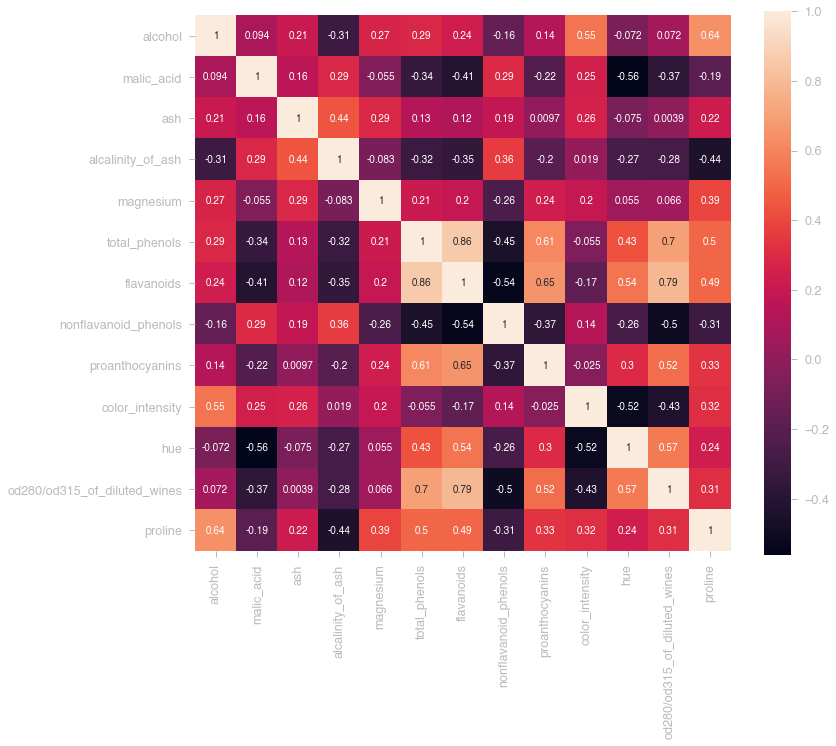

In [9]:
#Runs using Pearson correlation, values closer to 1/-1 implies strong positive/ negative correlation
corrmat = df_wine.corr()
f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corrmat, square=True, annot=True)

<AxesSubplot:>

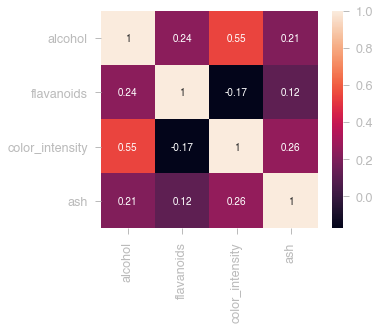

In [10]:
#Applying Pearson correlation to dataset with selected features
corrmat = df_wine[selected_features].corr()
f, ax = plt.subplots(figsize=(5,4))
sns.heatmap(corrmat, square=True, annot=True)

### Conclusion
At first glance and using a correlation matrix, it seems that stronger correlations are between color_intensity and alcohol. However it is important to verify correlations adding classes to the visualisation.

### 1.1. Visualising the data

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at hand.  When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features. 

The following image shows what such a visualisation might look like on the Iris dataset that you worked on during the Topic exercises. 

![image.png](attachment:image.png)


In [12]:
#selects a subset
feature_names = selected_features
feature_names

['alcohol', 'flavanoids', 'color_intensity', 'ash']

In [13]:
# define plotting function
def myplotGrid(X,y,feature_names):
    ''' 
     Function creates a grid of plots to assist the Exploratory Data Analysis.
    Each graph consists of a scatter plot where each feature is plotted against another and on the diagonal,
    a histogram with the value distribution for each variable.
    Parameters:
    X (float): Input data
    y (int): Target data
    feature_names (str) : list of feature names as given: alcohol, flavanoids, color_intensity and ash
    Returns:
    Figure
    '''
    f, axs= plt.subplots(len(feature_names),len(feature_names), figsize=(30,30))
    plt.suptitle('Exploratory Data Analysis', fontdict={'family': 'sans-serif','color': 'plum', 'weight': 'bold', 'size': 20})
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
            if i==j:
                axs[i,i].hist(X[:,i])
                axs[i,i].set_xlabel(feature_names[i])
                axs[i,i].set_ylabel('instances')
            else:
                axs[j,i].scatter(X[:,i],X[:,j], c=y, cmap=plt.cm.Paired)
                axs[j,i].set_xlabel(feature_names[i])
                axs[j,i].set_ylabel(feature_names[j])
    plt.show()
    

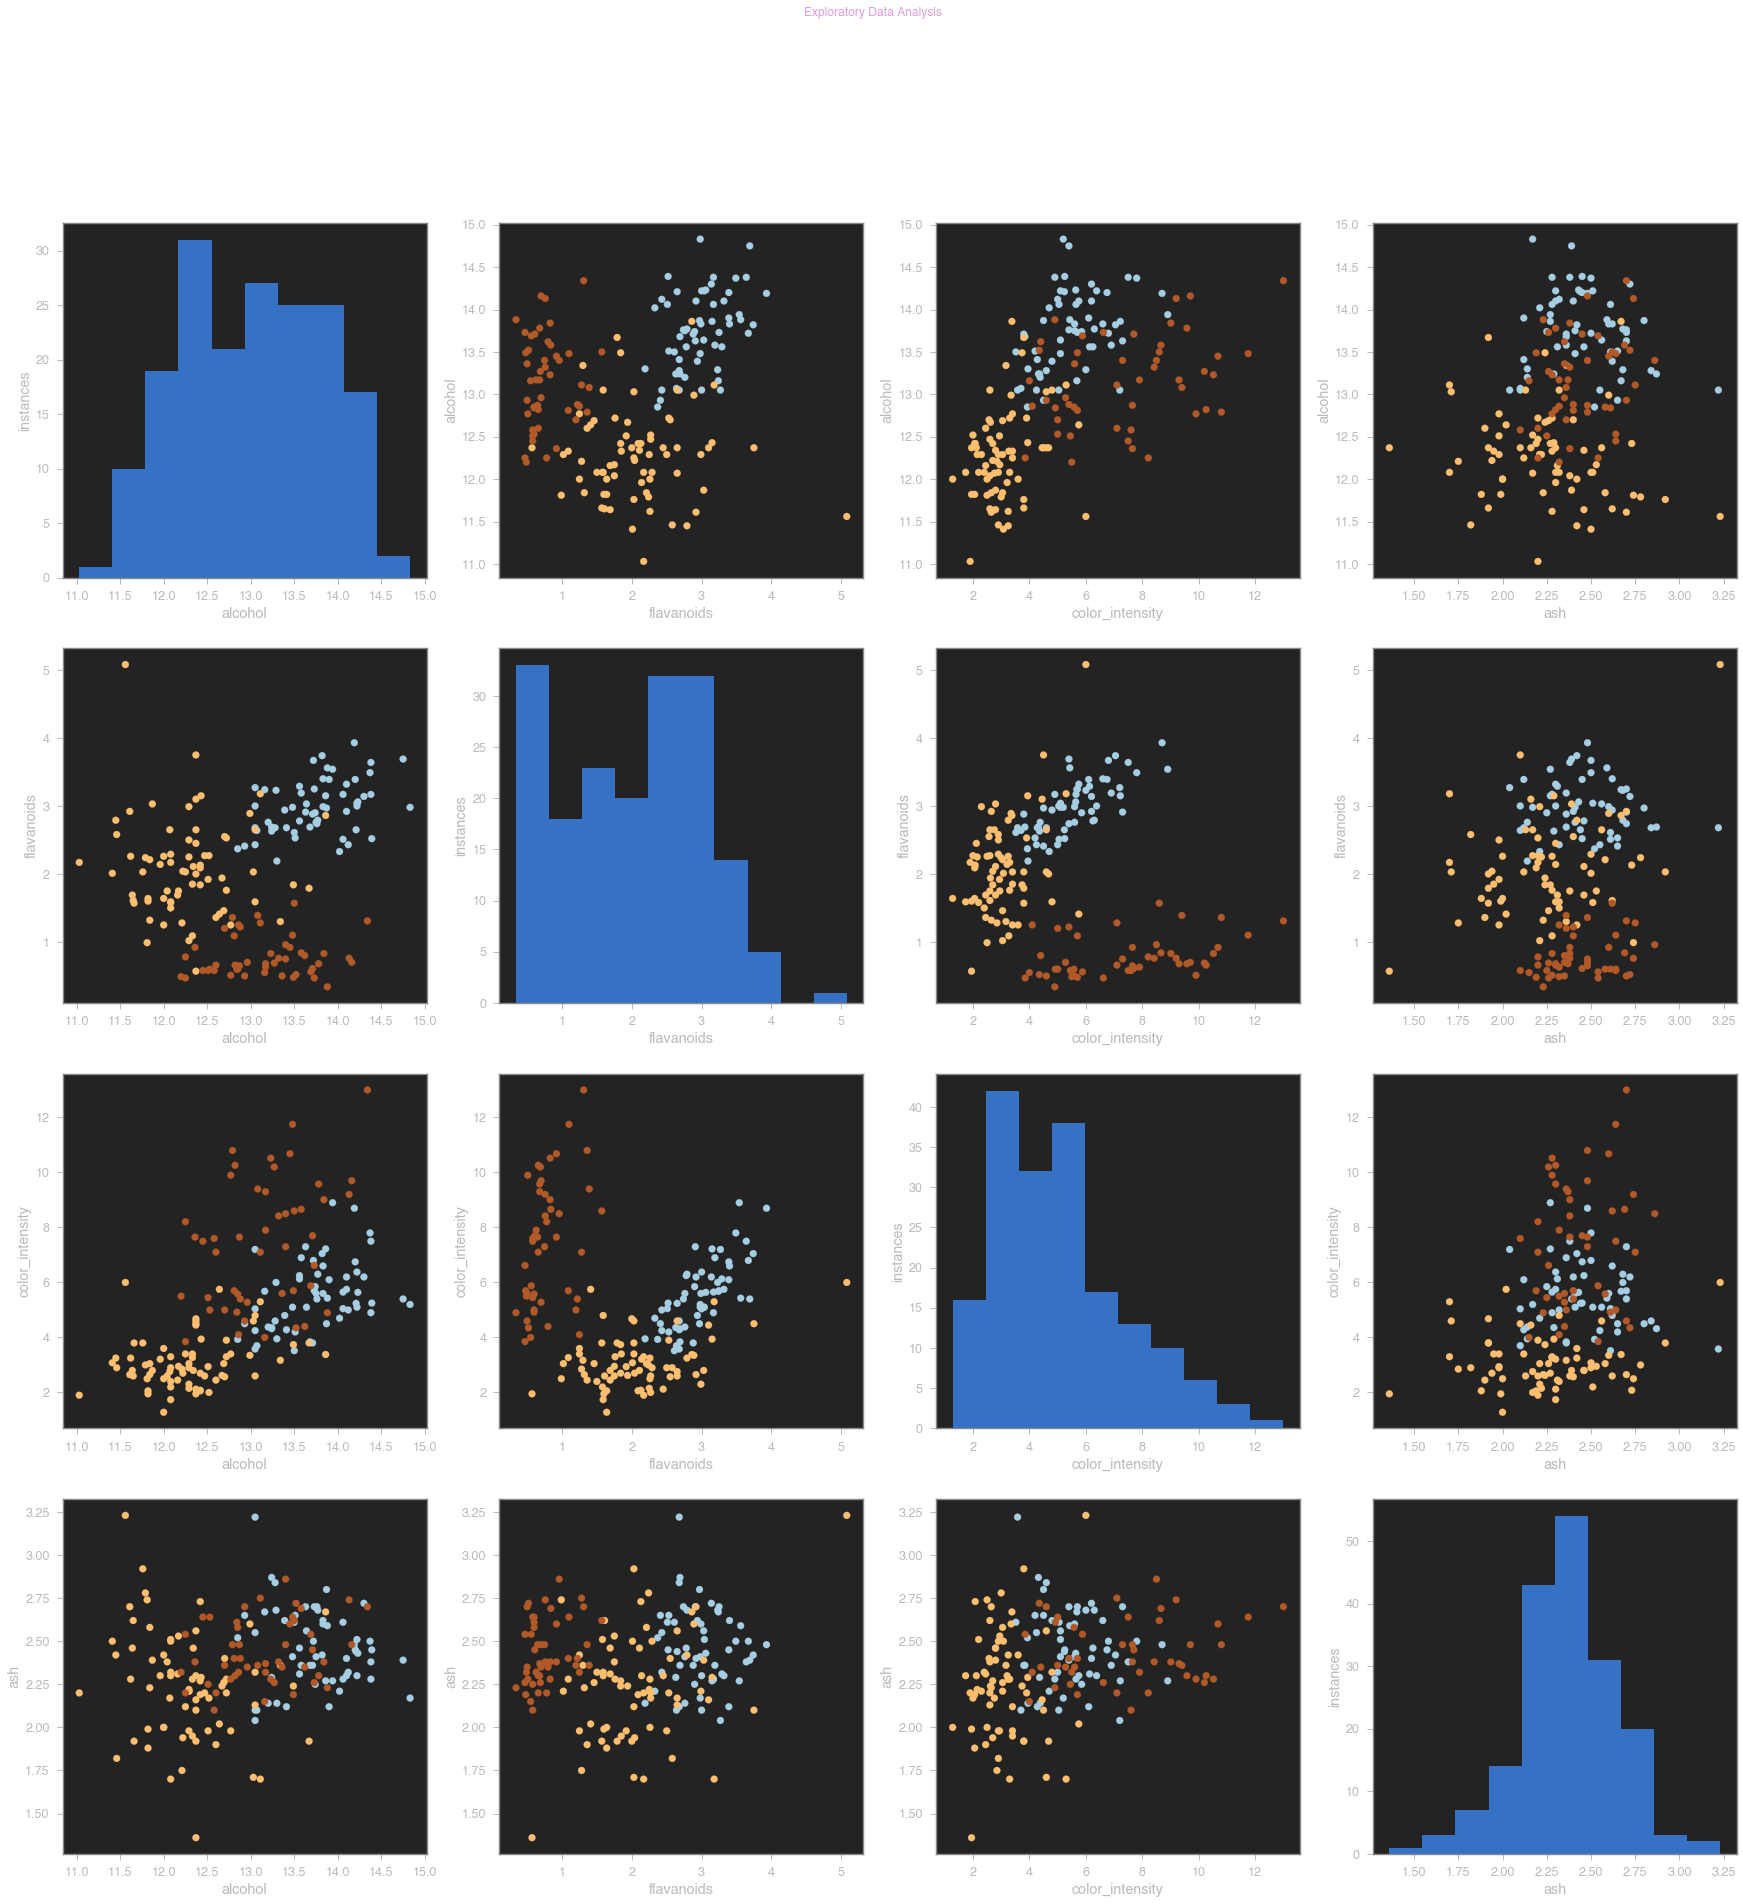

In [14]:
# run the plotting function
myplotGrid(X,y,feature_names)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging.

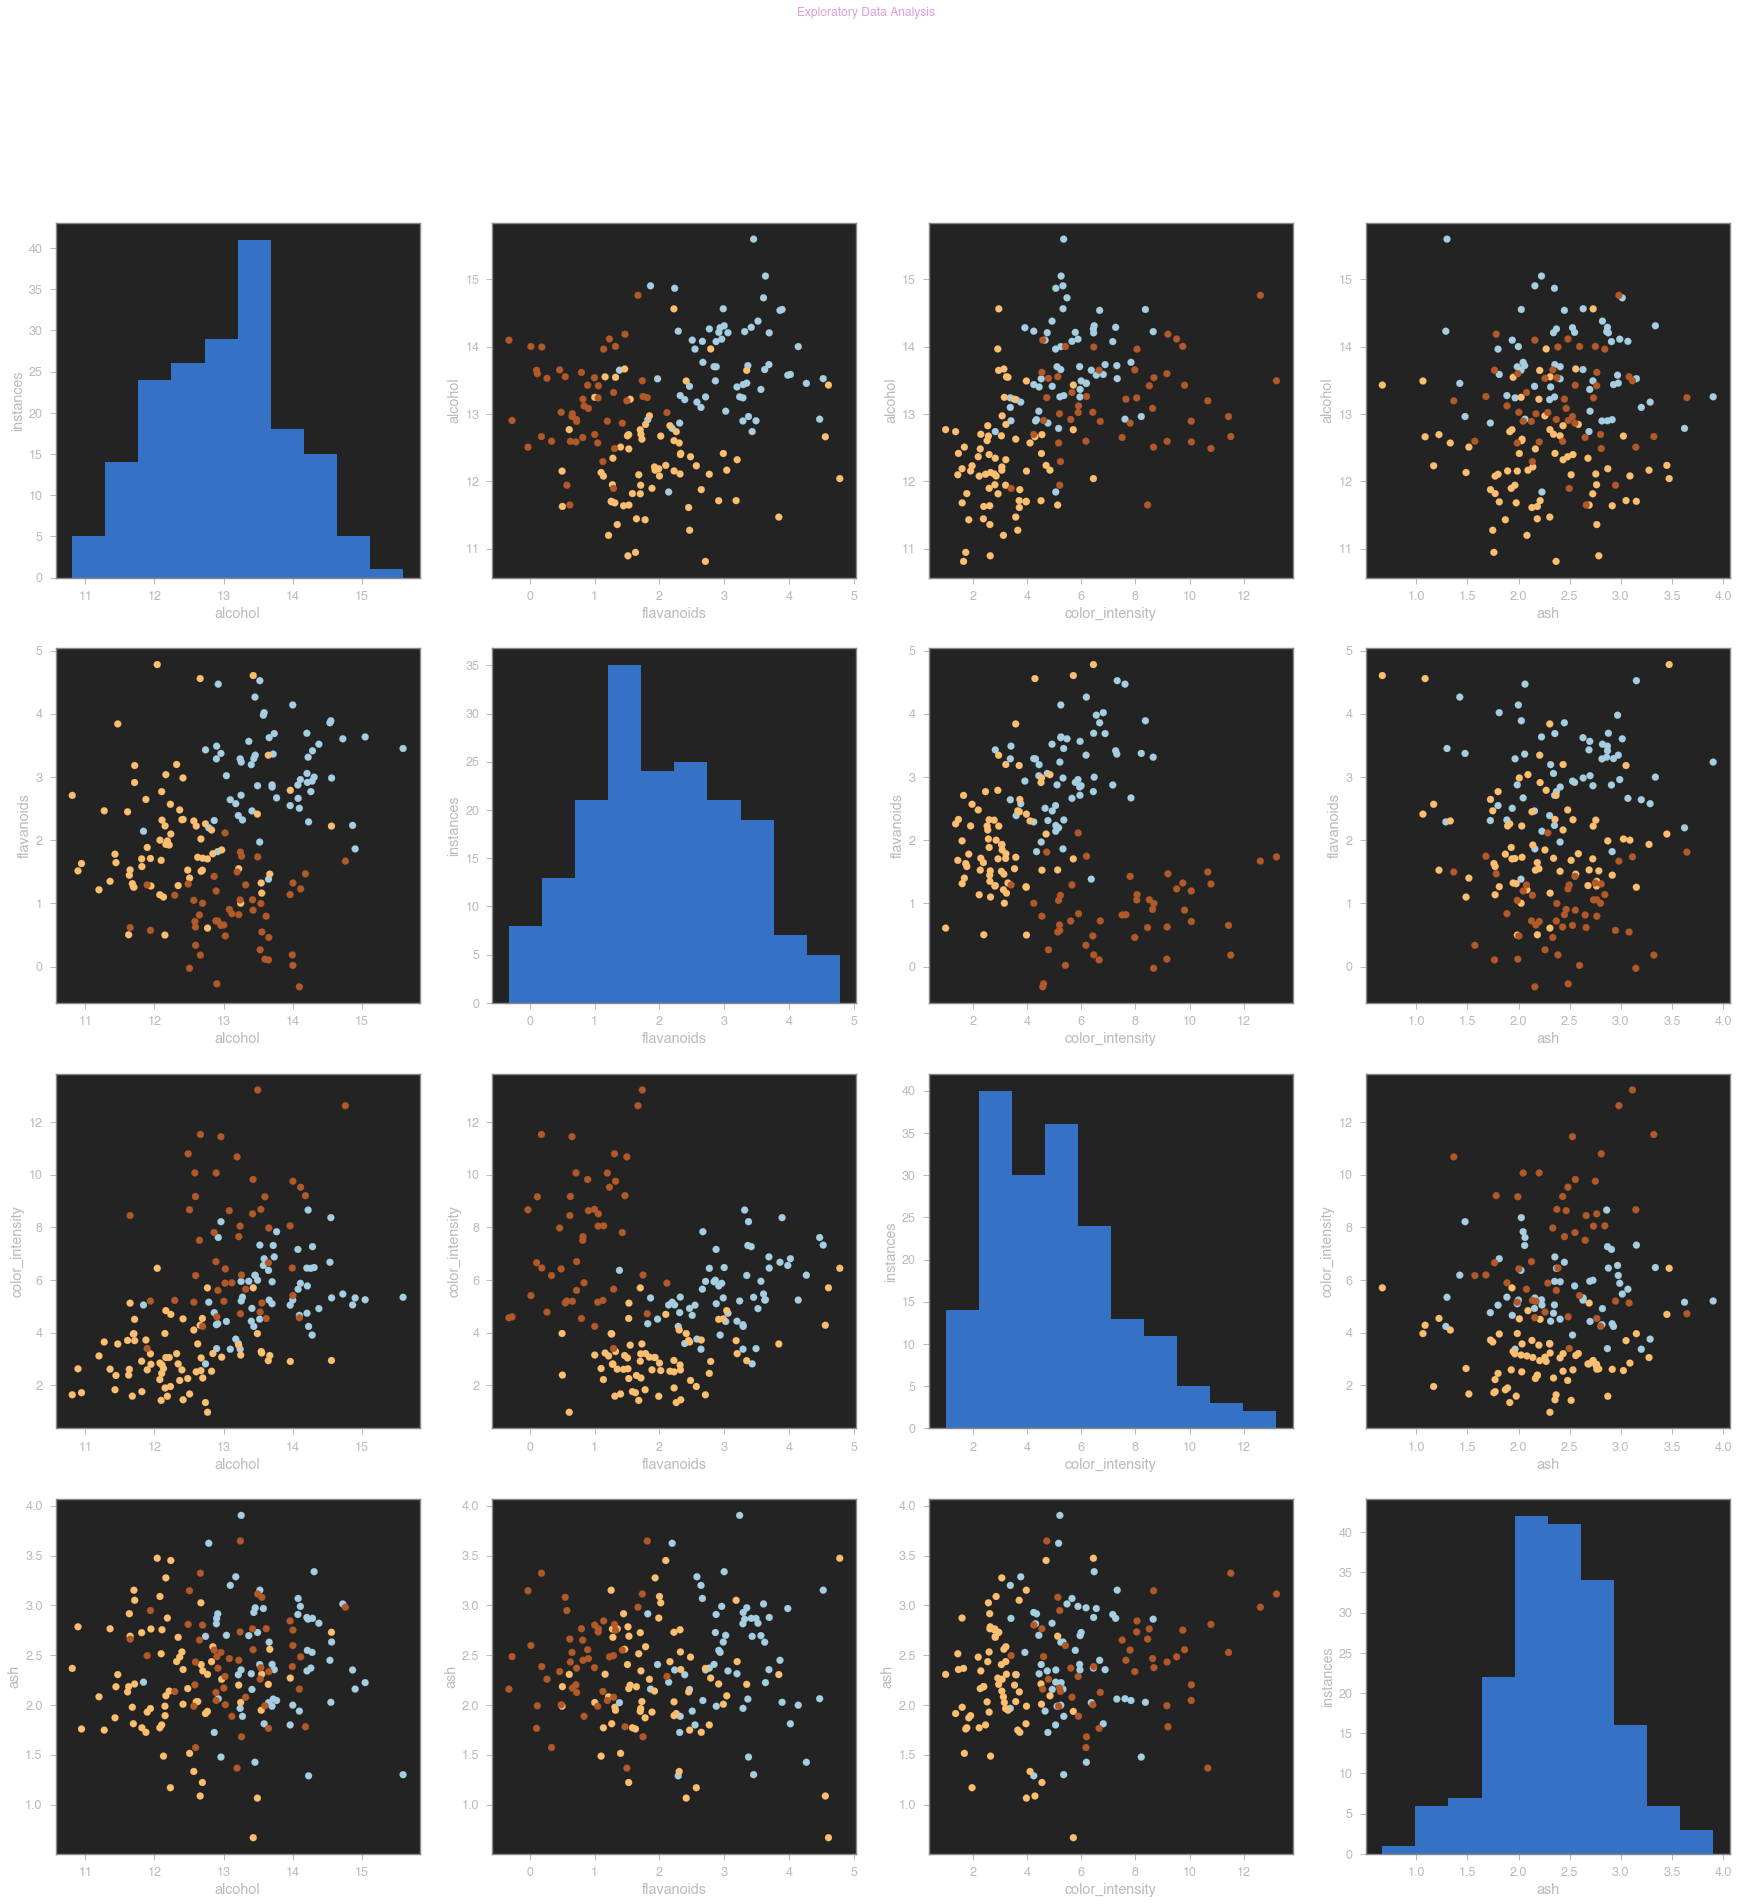

In [15]:
# noise code 
mySeed = 71019
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.5,X.shape)
myplotGrid(XN,y, feature_names)


#### Conclusions
Based on EDA, the 2 features I would select for my Classifier would be: flavanoids and color_intensity because in plotting the 3 classes, distribution of data points is more for those 2 features as opposed to other ones such as as ash and alcohol where classes seem to overlap more. The classifier ultimately is a binary classification or Boolean that will return True/ False. A classification model will contain multiple classifications or class labels. Distributions where classes overlap less, tend to have a smaller error and hence better prediction scores.

### Data with noise

I noticed a higher dispersion in the distribution of features with less distincted classes. For example with added Gaussian noise color_intensity and ash appear to have more overlapping of datapoints compared other combinations such as color_intensity and flavanoids, which are the 2 selected features for my Classifier model. Noise data is necessary to stress test the model and ensure it can handle noise in production.

## 2. Implementing kNN

In the cell below, I show how to implement k-Nearest Neighbour classification.

In [16]:
#To begin, data needs to be reshaped by concatenating X and y and re-indexing
data=np.concatenate((X,y.reshape(178,1)), axis=1)
#Subsequently will need to shuffle original data and noise data
np.random.seed(mySeed)
np.random.shuffle(data)
#Next, we need to create to 2 distinctive datasets: 80% allocated to training the model and the rest for testing it 
traindata=data[:120,:]
testdata=data[120:,:]
#Redefine X and y
X_train=traindata[:,:-1]
y_train=traindata[:,4]
X_test=testdata[:,:-1]
y_test=testdata[:,4]

#### Methodology note

<p>Next section  will create 2 functions for calculating distance measures Euclidean and Manhattan, to establish the similarity across vectors.</p>
<p>Euclidean formula is $$d(p,q)=√((q_{1}-p_{1})^2+(q_{2}-p_{2})^2)$$</p>
<p>Manhattan formula is $$d=|x_{1}^{a}-x_{1}^{b}|+|x_{2}^{a}-x_{2}^{b}|+|x_{3}^{a}-x_{3}^{b}|+|x_{4}^{a}-x_{4}^{b}|$$</p>

In [17]:
def euclidean(p,q):
    '''
    Function calculates Euclidean distance between two points using from numpy np.linalg.norm()
    Parameters:
    p,q(float): 1d array-type with two given points (p,q)
    Returns:
    e (float): The distance between given two points which is a scalar
    '''
    e = np.linalg.norm(p - q)
    return e

In [18]:
def manhattan(p,q):
    '''
    This function calculates the manhattan distance given two points.
    Parameters:
    p,q(float): 1d array-type Two given points
    Returns:
    e (float): The distance between the two points which is a scalar
    Original Manhattan Formula is: Σ|Ai – Bi|
    '''
    m = np.linalg.norm(p - q, ord =1, axis = 0)
    return m

In [19]:
def findNeighbours(trainingX,testpoint,k=5,metric='euclidean'):
    '''
    This function finds the closest neighbours to the centroid or test point.
    Parameters:
    trainingX (float): array-like, training data set from which function finds closest neighbours
    testpoint (float): 1d-array-like, test point for which function finds closest neighbours
    k(int):Scalar (Default=5) Number of neighbours to find
    metric(str): (Default='euclidean') refers to distance measure which can either be 'euclidean' or 'manhattan'
    Returns: 
    neighbours (int): array-like vector, a list of indices of k neighbours in training data
    '''
    #Step 1) measure distance between test point and each cluster point in training data
    #Distance measure can either be 'euclidean' or 'manhattan'
    index=[]
    distance=[]
    for i in range(trainingX.shape[0]):      
        if metric=='manhattan':
            d=manhattan(trainingX[i],testpoint)
        elif metric=='euclidean':
            d=euclidean(trainingX[i],testpoint)
        #Next creates 2 lists using index and distance to create vector matrix
        index.append(int(i))
        distance.append(d)
    #Turns the vector matrix into a Pandas data frame to enable subsequent calculations / operations such as sorting
    toSort=pd.DataFrame(columns=['index','distance'])
    toSort['index']=index
    toSort['distance']=distance
    sortedDist=toSort.sort_values('distance',ascending=True)
    #Once sorted, creates a new numpy array called 'neighbours' with only indeces values
    neighbours=sortedDist.iloc[:k,0].values
    return neighbours

In [20]:
# mykNN code
def mykNN(X,y,X_,k=5,metric='euclidean'):
    '''
    Function predicts categories by k nearest neighbours
    Accepts following arguments: input variables from test set, inputs and targets from training set,
    a "k" number of neighbours and distance measure between cluster points
    Function finds nearest neighbours for each point and assigns most frequent category.
    Parameters:
    X(float): array-like training input data
    y(int): array-like training target data
    X_(float): array-like test input data
    k (int): (Default=5) scalar k neighbors to find and assign the categorical value.
    metric (str): (Default='euclidean') possible arguments are: 'euclidean' or 'manhattan'.
    Return:
    y_predicted: array-like vector predicted target values for the test data.
    '''
    #Starts wtih empty list where predicted values will be stored
    y_predicted=[]
    #I iterate over the X_test
    for i in range(X_.shape[0]):
        #Draws on function "findNeighbours" function to training data, given k point and distance measure
        neighbours=findNeighbours(X,X_[i],k,metric)
        #Create list of knn classes using the indeces
        neighbourclasses=[y[int(neighbours[j])] for j in range(k)]
        #Creates empty array: first column stores count values for each class distribution,
        #second column adds indices from column 1
        sumclasses=np.zeros((3,2))
        for n in range(k):
            if neighbourclasses[n]==0:
                sumclasses[0][0]+=1
                sumclasses[0][1]+=n
            elif neighbourclasses[n]==1:
                sumclasses[1][0]+=1
                sumclasses[1][1]+=n
            else:
                sumclasses[2][0]+=1
                sumclasses[2][1]+=n
        #Using new array, look for most frequent class to be allocated to the test point
        if sumclasses[0,0]>sumclasses[1,0] and sumclasses[0,0]>sumclasses[2,0]:
            y_=0
        elif sumclasses[1,0]>sumclasses[0,0] and sumclasses[1,0]>sumclasses[2,0]:
            y_=1
        elif sumclasses[2,0]>sumclasses[0,0] and sumclasses[2,0]>sumclasses[1,0]:
            y_=2
        #For cases where counts were equal for two most frequent classes,then it looks for the closest category, using 
        #the values in the second column
        elif sumclasses[0,0]==sumclasses[1,0] and sumclasses[0,0]>sumclasses[2,0]:
            if sumclasses[0,1]<sumclasses[1,1]:
                y_=0
            else:
                y_=1
        elif sumclasses[0,0]==sumclasses[2,0] and sumclasses[0,0]>sumclasses[1,0]:
            if sumclasses[0,1]<sumclasses[2,1]:
                y_=0
            else:
                y_=2
        elif sumclasses[1,0]==sumclasses[2,0] and sumclasses[1,0]>sumclasses[0,0]:
            if sumclasses[1,1]<sumclasses[2,1]:
                y_=1
            else:
                y_=2
        #Same as before, in cases where number of neighbours is equal for the three categories, it looks for the closest category
        #this will be unlikely in the given data looking at the exploratory graphs
        elif sumclasses[0,0]==sumclasses[1,0]==sumclasses[2,0]:
            if sumclasses[0,1]<sumclasses[1,1] and sumclasses[0,1]<sumclasses[2,1]:
                y_=0
            elif sumclasses[1,1]<sumclasses[0,1] and sumclasses[1,1]<sumclasses[2,1]:
                y_=1
            elif sumclasses[2,1]<sumclasses[0,1] and sumclasses[2,1]<sumclasses[1,1]:
                y_=2
        #each value is stored in the list created in the first place
        y_predicted.append(y_)
    return y_predicted    


In [21]:
y_predicted=mykNN(X_train,y_train,X_test,10,'manhattan')
#Check results
print(y_predicted)

[1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 2, 2, 0, 2, 1, 0, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 0, 2, 2, 2]


## 3. Classifier evaluation

In the cell below, I implement my own classifier evaluation code, including confusion matrices, as well as common metrics like accuracy.

In [23]:
# confusion matrix function
def myConfMat(y_test,y_predicted,noOfclasses):
    '''
    This function creates a confusion matrix, showing which values were correctly and incorrectly classified 
    Parameters:
    y_test(int): array-like vector, this is test target data.
    y_pred(int): array-like vector, predicted values generated by mykNN function from training & test data
    noOfclasses (int): scalar, amount of different classes in test data
    Returns:
    C(int): array-like: confusion matrix
    '''
    C=np.zeros((noOfclasses, noOfclasses))
    for i in range(noOfclasses):
        for j in range(noOfclasses):
            for a in range(len(y_test)):
                if y_test[a]==i and y_test[a]== j and y_test[a]==y_predicted[a]:
                    C[i][j] +=1
                elif y_test[a] == i and y_test[a]!=y_predicted[a] and y_predicted[a]==j:
                    C[i][j] +=1
    return C
# accuracy function
def totalAccuracy(y_test,y_predicted):
    '''
    Function that shows total accuracy of the model, which is the ratio of correctly clasiffied points over total number of points.
    Parameters:
    y_test(int): array-like- vector, test target data
    y_predicted(int): array-like- vector, predicted values obtained by mykNN function from training & test data
    Returns:
    accuracy(float): scalar, total accuracy of the model
    '''
    correct=0
    for i in range(len(y_test)):
        if y_test[i]==y_predicted[i]:
            correct+=1
    accuracy=correct/len(y_test)*100
    return accuracy
# class accuracy function
def classAccuracy(y_test,y_predicted,ClassNo):
    '''
    Function that shows total accuracy of the model, which is the ratio of correctly clasiffied points over total number of points within a class.
    Parameteres:
    y_test(int): array-like- vector, test target data
    y_predicted(int): array-like- vector, predicted values obtained by mykNN function from training & test data
    ClassNo(int): count of selected class
    Returns:
    classAcc(float): scalar. The total accuracy of the model for a particular class.
    '''
    correct=0
    totalclass=0
    for i in range(len(y_test)):
        if y_test[i]==ClassNo:
            totalclass+=1
            if y_test[i]==y_predicted[i]:
                correct+=1
    classAcc=correct/totalclass*100
    return classAcc

In [24]:
# test evaluation code
print(myConfMat(y_test,y_predicted,len(np.unique(y))))
print('Model accuracy: '+str(round(totalAccuracy(y_test,y_predicted),2)))
print('Class 0 accuracy: '+str(round(classAccuracy(y_test,y_predicted,0),2)))
print('Class 1 accuracy: '+str(round(classAccuracy(y_test,y_predicted,1),2)))
print('Class 2 accuracy: '+str(round(classAccuracy(y_test,y_predicted,2),2)))

[[21.  0.  0.]
 [ 4. 13.  1.]
 [ 0.  0. 19.]]
Model accuracy: 91.38
Class 0 accuracy: 100.0
Class 1 accuracy: 72.22
Class 2 accuracy: 100.0



## 4. Nested Cross-validation using your implementation of KNN  [6 pts]

In the cell below, I developed my implementation for 5-fold nested cross-validation along with the implemenation of k-NN above.

In [26]:
def splitIterateData(b, folds, Data):
    '''
    Function splits data into training input, training target,test input and test target for each iteration
    within a loop for cross or nested cross-validation.
    Function takes the following arguments: each b iterates over folds, will take a subset that will be test set with 
    the remaining being the training set. End result will be 4 arrays with data labelled as input and target.
    Parameters:
    b (int): scalar. A value which will change in the loop from 0 to fold-1.
    folds (int): Scalar. The number of folds to do the cross-validation.
    Data(float): array-like. All the data which will be separated into the training set and test set and inputs and targets.
    Returns:
    X_train (float): array-like, training input data
    y_train (int): array-like vector, training target data 
    X_test (float): array-like, test input data.
    y_test (int): array-like vector, test target data
    '''
    c=b+1 #b is value that iterates in the loop. c is an additional parameter that adds a unit to b.
    #B and C are number which help divide the data into folds, are calculated by multiplying
    #b and c by number of data points and dividing by number of folds.
    #for example in the second loop for wine data with 5 folds, b=1,c=2, B=30, C=60
    C=int(c*(Data.shape[0]/folds))
    B=int(b*(Data.shape[0]/folds))
    #when b equal 0 and b equals folds-1, data is split into test and train.
    if b==0:
        testData=Data[:C]
        trainData=Data[C:]
    elif b==(folds-1):
        trainData=Data[:B]
        testData=Data[B:]
    #for everything else, test set splits data into 2 sides that will need to be concatenated
    else:
        train1=Data[:B]
        testData=Data[B:C]
        train2=Data[C:]
        trainData=np.concatenate((train1,train2))
    #Final output are 4 arrays for train and test for variables X and y
    X_train=trainData[:,:-1]
    y_train=trainData[:,4]
    X_test=testData[:,:-1]
    y_test=testData[:,4]
    return X_train, y_train, X_test, y_test

In [27]:
def findMostFreq(listofvalues):
    '''
    Function finds most frequent values.
    Parameters:
    listofvalues (list): The list can contain either numbers or strings.
    Returns:
    mostfreq: it can be either a string or a scalar.
    '''
    counts={} #creates an empty dictionary
    for val in listofvalues: # Iterates over values in list.
        if val in counts: #Counts each time the value appears in the list
            counts[val]+=1
        else:
            counts[val]=1 #starts from 1 for each new value
    furthercounts=1
    for val in listofvalues: #further iteration over list of values
        if counts[val]>furthercounts: # Validates that each count is higher than furthercounts
            #When a specific value is the most frequent, the furthercounts take the number of counts
            furthercounts= counts[val]
            mostfreq=val
    return mostfreq

In [28]:
# myNestedCrossVal code
def myNestedCrossVal(X,y,folds=5,klist=list(range(1,11)),metrics=['euclidean','manhattan'],seed=mySeed):
    '''
    Function outputs a nested cross-validation for k-Nearest Neighbours, given initial data, number of folds,
    list of Ks, and list of distance measures and a seed number.  
    Function returns a nested cross validation with KNN and returns a list of accuracies and prints for each fold best k,
    best metric, accuracy and confusion matrix
    Parameters:
    X(float): array-like, training input data
    y(int): array-like, training target data
    folds(int): number of folds to perform nested cross-validation
    klist (int):(Default=list(range(1,11))) List of k neighbours to find and assign the categorical value.
    metrics (str): (Default=['euclidean','manhattan']) List of the system metric to find the distance between two points.
    seed (int): The seed number is a value which help get everytime the same data when using a function that randomise.
    Returns:
    Accuracy_list(float): List- A list of the accuracies for each fold.
    '''
    #Creates data by concatenating X and y
    Data=np.concatenate((X,y.reshape(178,1)), axis=1)
    np.random.seed(seed) 
    np.random.shuffle(Data) #Shuffles data
    Accuracy_list=list() #Creates empty list for accuracy
    for b in range(folds): #iterates over number of folds
        #For each fold, creates different training and tests Xs and ys 
        X_train, y_train, X_test, y_test=splitIterateData(b, folds, Data)
        #Concatenates the X_train and y_train which will be used as single dataset for training and validation.
        train_val_data=np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)
        Ksval=[] #Creates an empty list of ks
        Distvals=[] #Creates an empty list of the distances
        for b in range(folds): #iterates over same number of folds
            #Divides initial training data into training and validation Xs and ys
            X_train_small, y_train_small, X_val, y_val=splitIterateData(b, folds, train_val_data)    
            best_accuracy=0 #creates value to store accuracy, starts from 0.
            for k in klist: #Iterates over list of ks 
                for dist in metrics: #Iterates over list of metrics
                    #Runs kNN model within the training small data and input validation data for each k and distance
                    y_pred_val=mykNN(X_train_small,y_train_small,X_val,k,metric=dist)
                    #Calculates model accuracy given predicted validation values and test validation set
                    acc=totalAccuracy(y_val,y_pred_val)
                    if acc>= best_accuracy: 
                        #When accuracy is equal or bigger than best accuracy, it changes the value of the best accuracy with
                        #the accuracy of the model, it stores the k and the distances as the bestk and best_dist
                        best_accuracy=acc
                        best_k=k
                        best_dist=dist
            #At each inner fold best ks and distances are appended to lists
            Ksval.append(best_k)
            Distvals.append(best_dist)
        #Uses function findmostFreq to find most frequent ks and distances as best overall parameters
        bestK=findMostFreq(Ksval)
        bestDist=findMostFreq(Distvals)
        print("Best K number is: "+str(bestK)) #values for each fold
        print("Best distance metric is: "+bestDist)
        y_predicted=mykNN(X_train,y_train,X_test,k=bestK, metric=bestDist) #Performs again knn using all training data
        #and testing on actual test data
        accuracy=totalAccuracy(y_test,y_predicted) #Calculates accuracy of KNN for each fold
        Accuracy_list.append(accuracy) #Appends accuracy in list 
        print("Accuracy in this fold is:"+str(round(accuracy,2))) #Prints results
        print(myConfMat(y_test,y_predicted,len(np.unique(y)))) #Prints confusion metrix for this fold
    return Accuracy_list
    

In [31]:
# evaluate clean data code
Accuracy_list=myNestedCrossVal(X,y,folds=5,klist=list(range(1,11)),metrics=['euclidean','manhattan'],seed=mySeed)

Best K number is: 6
Best distance metric is: manhattan
Accuracy in this fold is:97.14
[[10.  0.  0.]
 [ 1. 13.  0.]
 [ 0.  0. 11.]]
Best K number is: 4
Best distance metric is: manhattan
Accuracy in this fold is:97.22
[[15.  0.  0.]
 [ 1. 13.  0.]
 [ 0.  0.  7.]]
Best K number is: 8
Best distance metric is: manhattan
Accuracy in this fold is:88.57
[[ 9.  0.  0.]
 [ 3. 14.  1.]
 [ 0.  0.  8.]]
Best K number is: 10
Best distance metric is: manhattan
Accuracy in this fold is:97.22
[[14.  0.  0.]
 [ 1. 13.  0.]
 [ 0.  0.  8.]]
Best K number is: 2
Best distance metric is: manhattan
Accuracy in this fold is:91.67
[[11.  0.  0.]
 [ 2.  8.  1.]
 [ 0.  0. 14.]]


In [33]:
# evaluate clean data code
print('mean Accuracy: '+ str(round(np.mean(Accuracy_list),2)))
print('Std. Dev. Accuracy: '+str(round(np.std(Accuracy_list),2)))

mean Accuracy: 94.37
Std. Dev. Accuracy: 3.6


In [34]:
NoisyDataAccuracy_list=myNestedCrossVal(XN,y,folds=5,klist=list(range(1,11)),metrics=['manhattan','euclidean'],seed=mySeed)

Best K number is: 9
Best distance metric is: euclidean
Accuracy in this fold is:97.14
[[ 9.  1.  0.]
 [ 0. 14.  0.]
 [ 0.  0. 11.]]
Best K number is: 10
Best distance metric is: euclidean
Accuracy in this fold is:94.44
[[15.  0.  0.]
 [ 1. 13.  0.]
 [ 1.  0.  6.]]
Best K number is: 10
Best distance metric is: euclidean
Accuracy in this fold is:88.57
[[ 7.  2.  0.]
 [ 1. 17.  0.]
 [ 0.  1.  7.]]
Best K number is: 10
Best distance metric is: euclidean
Accuracy in this fold is:91.67
[[13.  1.  0.]
 [ 1. 13.  0.]
 [ 1.  0.  7.]]
Best K number is: 10
Best distance metric is: manhattan
Accuracy in this fold is:80.56
[[10.  0.  1.]
 [ 4.  6.  1.]
 [ 0.  1. 13.]]


In [35]:
# evaluate noisy  data code
print('mean Accuracy: '+ str(round(np.mean(NoisyDataAccuracy_list),2)))
print('Std. Dev. Accuracy: '+str(round(np.std(NoisyDataAccuracy_list),2)))

mean Accuracy: 90.48
Std. Dev. Accuracy: 5.72


## 5. Summary of results

Using results from above, I compiled results in the following table using the **clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 97.14  |  6 | Manhattan  |
| 2 | 97.22  |  4 | Manhattan  |
| 3 | 88.57  |  8 | Manhattan  |
| 4 | 97.22  |  10 | Manhattan  |
| 5 | 91.67  |  2 | Manhattan  |
| **total** | 94.37 $\pm$ 3.6 |   |    |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 97.14  |  9 | Euclidean  |
| 2 | 94.44  |  10 | Euclidean  |
| 3 | 88.57  |  10 | Euclidean  |
| 4 | 91.67  |  10 | Euclidean  |
| 5 | 80.56  |  10 | Manhattan  |
| **total** | 90.48 $\pm$ 5.72 |   |    |


### 5.2. Confusion matrix summary

Next I will summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data).

In [36]:
# myNestedCrossValSingleMatrix code
def myNestedCrossValSingleMatrix(X,y,folds=5,klist=list(range(1,11)),metrics=['euclidean','manhattan'],seed=mySeed):
    '''
    Function outputs a nested cross-validation for k-Nearest Neighbours.
    Function takes as arguments initial data, number of folds, list of Ks, and list of distance measures and a seed number,
    function returns a big confusion metrix composed of confusion matrix of each fold.
    Parameters:
    X(float): array-like, training input data
    y(int): array-like, training target data
    folds(int): number of folds for performing nested cross-validation
    klist (int):(Default=list(range(1,11))) List of k neighbours to determine categorical value
    metrics (str): (Default=['euclidean','manhattan']) List of distance measures to calculate distance between two points.
    seed (int): seed number is a value to normalize data when using a function that randomise.
    Returns:
    big_conf_matrix (int): array-like. Summary confusion matrix which includes overall health of the model for all folds.
    '''
    Data=np.concatenate((X,y.reshape(178,1)), axis=1)
    np.random.seed(seed)
    np.random.shuffle(Data)
    for b in range(folds):
        X_train, y_train, X_test, y_test=splitIterateData(b, folds, Data)
        train_val_data=np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)
        Ksval=[]
        Distvals=[]
        for i in range(folds):
            X_train_small, y_train_small, X_val, y_val=splitIterateData(i, folds, train_val_data)    
            best_accuracy=0
            for k in klist:
                for dist in metrics:
                    y_pred_val=mykNN(X_train_small,y_train_small,X_val,k,metric=dist)
                    acc=totalAccuracy(y_val,y_pred_val)
                    if acc>= best_accuracy:
                        best_accuracy=acc
                        best_k=k
                        best_dist=dist
            Ksval.append(best_k)
            Distvals.append(best_dist)
        bestK=findMostFreq(Ksval)
        bestDist=findMostFreq(Distvals)
        y_predicted=mykNN(X_train,y_train,X_test,k=bestK, metric=bestDist)
        accuracy=totalAccuracy(y_test,y_predicted)
        conf_Matrix=myConfMat(y_test,y_predicted,len(np.unique(y)))
        #Creates final overall confusion matrix by concatenating all smaller ones
        if b!=0:
            overall_conf_matrix=np.concatenate((overall_conf_matrix,conf_Matrix))
        else:
            overall_conf_matrix=conf_Matrix
    return overall_conf_matrix
    

In [37]:
#Creates an array matrix to store overall confusion matrix with clean data
matrix=myNestedCrossValSingleMatrix(X,y,folds=5,klist=list(range(1,11)),metrics=['euclidean','manhattan'],seed=mySeed)
#Creates 3 columns and rows, in order to present final results in dataframe format
columns=['Pred Class 0','Pred Class 1','Pred Class 2']
indices=[['Fold1','Fold1','Fold1','Fold2','Fold2','Fold2','Fold3','Fold3','Fold3','Fold4','Fold4','Fold4',
          'Fold5','Fold5','Fold5'],['RT Class 0', 'RT Class 1', 'RT Class 2','RT Class 0', 'RT Class 1', 'RT Class 2',
          'RT Class 0', 'RT Class 1', 'RT Class 2','RT Class 0', 'RT Class 1', 'RT Class 2','RT Class 0', 'RT Class 1',
                                   'RT Class 2']]
#Creates a Pandas DataFrame which containing overall confusion matrix data
overall_matrix=pd.DataFrame(data=matrix, columns=columns, index=indices)
#Similarly for noisy data
noisy_matrix=myNestedCrossValSingleMatrix(XN,y,folds=5,klist=list(range(1,11)),metrics=['euclidean','manhattan'],seed=mySeed)
total_matrixnoisy=pd.DataFrame(data=noisy_matrix, columns=columns, index=indices)

In [38]:
print('CLEAN')
# clean data summary results
overall_matrix

CLEAN


Pred Class 0  Pred Class 1  Pred Class 2
Fold1 RT Class 0          10.0           0.0           0.0
      RT Class 1           1.0          13.0           0.0
      RT Class 2           0.0           0.0          11.0
Fold2 RT Class 0          15.0           0.0           0.0
      RT Class 1           1.0          13.0           0.0
      RT Class 2           0.0           0.0           7.0
Fold3 RT Class 0           9.0           0.0           0.0
      RT Class 1           3.0          14.0           1.0
      RT Class 2           0.0           0.0           8.0
Fold4 RT Class 0          14.0           0.0           0.0
      RT Class 1           1.0          13.0           0.0
      RT Class 2           0.0           0.0           8.0
Fold5 RT Class 0          11.0           0.0           0.0
      RT Class 1           2.0           8.0           1.0
      RT Class 2           0.0           0.0          14.0

In [39]:
print('NOISY')
# noisy data summary results
total_matrixnoisy

NOISY


Pred Class 0  Pred Class 1  Pred Class 2
Fold1 RT Class 0           9.0           1.0           0.0
      RT Class 1           0.0          14.0           0.0
      RT Class 2           0.0           0.0          11.0
Fold2 RT Class 0          15.0           0.0           0.0
      RT Class 1           1.0          13.0           0.0
      RT Class 2           1.0           0.0           6.0
Fold3 RT Class 0           7.0           2.0           0.0
      RT Class 1           1.0          17.0           0.0
      RT Class 2           0.0           1.0           7.0
Fold4 RT Class 0          13.0           1.0           0.0
      RT Class 1           1.0          13.0           0.0
      RT Class 2           1.0           0.0           7.0
Fold5 RT Class 0          10.0           0.0           1.0
      RT Class 1           4.0           6.0           1.0
      RT Class 2           0.0           1.0          13.0